In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tempfile, sys, os, pickle, glob, PIL, cv2, itertools
sys.path.insert(0, os.path.abspath('../..'))
#os.environ["CUDA_VISIBLE_DEVICES"]="-1" 
import matplotlib.pyplot as plt
import keras
from keras.applications.inception_v3 import InceptionV3
from keras import optimizers
from keras.models import Model
from keras import backend as K
import tensorflow as tf
import numpy as np 
from sklearn.metrics import confusion_matrix
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot
import innvestigate
import shap
from deepexplain.tensorflow import DeepExplain
from sklearn.preprocessing import normalize
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
from PIL import *
import matplotlib.cm as cm
%matplotlib inline
K.clear_session()
from dasp import DASP
from utils.utils import plot_mse_comparison, plot_correlation_comparison
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from utils.accuracy_robustness import run_robustness_test

Using TensorFlow backend.
/home/amitoj/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/amitoj/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/amitoj/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/amitoj/anaconda3/lib/python3.7/site-packages/tenso

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [2]:
#base = "/../../../scratch/amitoj/OCT2017/"
base = "../../hdd/Amitoj/OCT2017/"
base_attr = 'OCT-annotations/attributions_20_all/'
#base_attr = base + "attributions/"
x_test = np.load('annot_keras_20_all.npy')
y_test = np.array([[0 for i in range(x_test.shape[1])], [1 for i in range(x_test.shape[1])], [2 for i in range(x_test.shape[1])], [3 for i in range(x_test.shape[1])]])
#y_test = np.array([[0 for i in range(250)], [1 for i in range(250)], [2 for i in range(250)], [3 for i in range(250)]])
y_test_cat = keras.utils.to_categorical(y_test.flatten(), 4)
x_test_seq = x_test.reshape((x_test.shape[0]*x_test.shape[1], x_test.shape[2], x_test.shape[3], x_test.shape[4]))
xs = x_test_seq
ys = y_test_cat

In [3]:
dis = ['CNV', 'DME', 'DRUSEN', 'Normal']
explainers = ['shap_select', 'shap_rand', 'guided_backprop', 'deep_taylor', 'input_t_gradient', 'lrp.z', 'integrated_gradients',
              'gradient', "smoothgrad", "deconvnet", 'deeplift', 'saliency', 'occlusion', 'lrp.epsilon']
"""explainers = ['shap_select', 'shap_rand1', 'guided_backprop', 'deep_taylor', 'input_t_gradient', 'lrp.z', 'integrated_gradients',
              'gradient', "smoothgrad", "deconvnet", 'deeplift2', 'saliency2', 'lrp.epsilon', 'occlusion5']"""
explainer_labels = ['DcNet', 'DTaylor', 'DLift-Res', 'Grad', 'GBP', 'I*Grad', 'IG', 'LRP.E', 'LRP.Z', 'Occ64', 'Saliency', 'SHAP-R', 'SHAP-S', 'SmoothGrad']
explainers.sort()
"""for e, exp in enumerate(explainers):
    print(e, exp)"""

'for e, exp in enumerate(explainers):\n    print(e, exp)'

In [4]:
attr_arr = [] #attributions of all explainers for given weight
for exp in explainers:
    filename = base_attr + exp + '_model_' + str(0) + '.npy'
    attr_arr.append(np.load(filename))
    

In [5]:
explainer_labels_no_z = explainer_labels.copy()
explainer_labels_no_z.pop(8)
attr_arr_no_z = attr_arr.copy()
attr_arr_no_z.pop(8)
explainer_labels_no_z

['DcNet',
 'DTaylor',
 'DLift-Res',
 'Grad',
 'GBP',
 'I*Grad',
 'IG',
 'LRP.E',
 'Occ64',
 'Saliency',
 'SHAP-R',
 'SHAP-S',
 'SmoothGrad']

In [6]:
model = InceptionV3(include_top=True, weights= None, classes=4)
adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
weight_addrs = glob.glob('../Kermany_inception/top_weights/*')
model.load_weights(weight_addrs[0])

Instructions for updating:
Colocations handled automatically by placer.


Running robustness test...
Input shape ((80, 299, 299, 3)) is not equal to map shape ((80, 299, 299))


/home/amitoj/Projects/Explainability/utils/accuracy_robustness.py:54: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


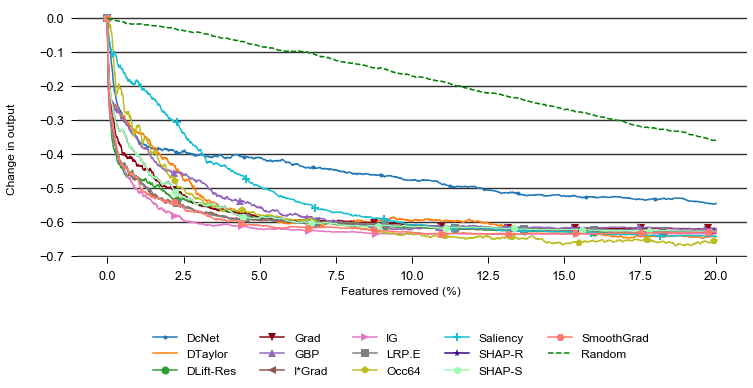

In [7]:
init_notebook_mode(connected=True)
input_tensor = model.layers[0].input
fModel = Model(inputs=input_tensor, outputs = model.layers[-1].output)
run_robustness_test(model, xs, ys,  [x.reshape(x.shape[0]*x.shape[1], x.shape[2], x.shape[3]) for x in attr_arr_no_z], [y for y in explainer_labels_no_z], 'cifar10', 10,
                        result_path='.', mode='prediction', reduce_dim=None)

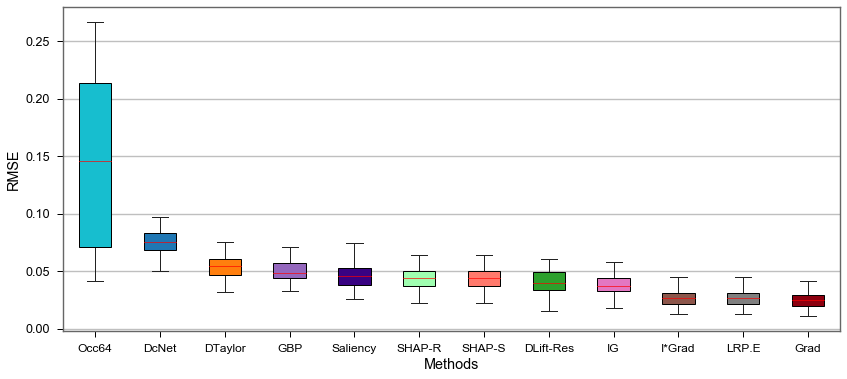

In [8]:

plot_mse_comparison("mnist_cnn", [x.reshape(x.shape[0]*x.shape[1], x.shape[2], x.shape[3]) for x in attr_arr_no_z], [y for y in explainer_labels_no_z], gt_idx=-1)

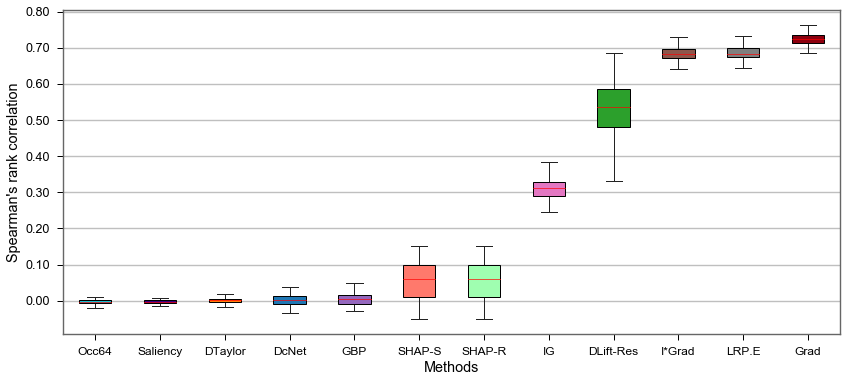

In [9]:
plot_correlation_comparison("mnist_cnn", [x.reshape(x.shape[0]*x.shape[1], x.shape[2], x.shape[3]) for x in attr_arr_no_z], [y for y in explainer_labels_no_z], gt_idx=-1)

In [10]:
#plot_correlation_comparison("mnist_cnn", [x for x in attr_arr_no_occ], [y for y in explainer_labels_no_occ], gt_idx=-1)

## Quantitative comparison (pixel perturbation)
Pixels in the original images are ranked by their attribution value and sequentially "removed" by setting their value to zero. We expect good explanations to highlight pixels that are important for the classification. Assuming that the importance of a pixels is positively correlated with its marginal contribution to the output, we expect the target output to drop faster when the most important pixels are removed first. These curve showa the output variations while pixels are removed according to the ranking given by the different methods. Better methods produce the largest variations. See "Evaluating the visualization of what a Deep Neural Network has learned", Samek et al., 2015 for details.